In [11]:
import os
import itertools
import shutil
import random
import glob
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
random.seed(123)

Check that GPU acceleration is being used

In [3]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1


Set paths

In [17]:
training_data_path = "../data/training_images"
validation_data_path = "../data/validation_images"
test_data_path = "../data/test_images"

Image preprocessing

In [18]:
training_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = training_data_path, target_size = (230,230), classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], batch_size = 10)
    
validation_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = validation_data_path, target_size = (230,230), classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], batch_size = 10)
    
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory = test_data_path, target_size = (230,230), classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"], batch_size = 10, shuffle = False)

Found 2439 images belonging to 4 classes.
Found 431 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


Preprocess a image batch

In [19]:
imgs, labels = next(training_batches)

Image batch plotting function

In [20]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Plot and print labels for the preprocessed image batch

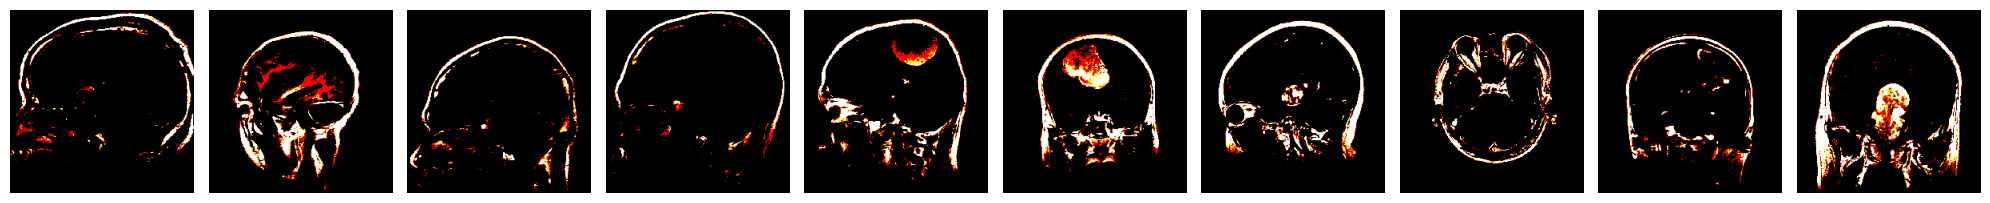

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [21]:
plotImages(imgs)
print(labels)

Build model

In [22]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", padding = "same", input_shape = (230,230,3)), 
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = "same",),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Flatten(),
    Dense(units = 4, activation = "softmax")
    ])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 230, 230, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 115, 115, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 115, 115, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 57, 57, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 207936)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                

In [24]:
model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [25]:
model.fit(x = training_batches,
          validation_data = validation_batches,
          epochs = 20)

Epoch 1/20


2024-03-01 14:37:56.256088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-01 14:37:56.276272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


244/244 [==============================] - 7s 23ms/step - loss: 8.9292 - accuracy: 0.6650 - val_loss: 1.9755 - val_accuracy: 0.7471
Epoch 2/20
244/244 [==============================] - 5s 20ms/step - loss: 0.3953 - accuracy: 0.9065 - val_loss: 2.0768 - val_accuracy: 0.6868
Epoch 3/20
244/244 [==============================] - 5s 19ms/step - loss: 0.0653 - accuracy: 0.9795 - val_loss: 1.8960 - val_accuracy: 0.6497
Epoch 4/20
244/244 [==============================] - 5s 19ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 1.3623 - val_accuracy: 0.7703
Epoch 5/20
244/244 [==============================] - 5s 19ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 1.2696 - val_accuracy: 0.7749
Epoch 6/20
244/244 [==============================] - 5s 20ms/step - loss: 9.8623e-04 - accuracy: 1.0000 - val_loss: 1.3354 - val_accuracy: 0.7680
Epoch 7/20
244/244 [==============================] - 5s 20ms/step - loss: 6.5271e-04 - accuracy: 1.0000 - val_loss: 1.3592 - val_accuracy: 0.7680
Ep